
# Урок 6. Расчёт длительности А/B теста + продвинутые топики

In [1]:
#from math import asin

#import numpy as np

from scipy import stats
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power, zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.meta_analysis import effectsize_smd

from typing import Union

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.graph_objects as go

In [2]:
#Расчёт effect_size для пропорций (качественная)
def calc_propotion_effect_size(conv1: int, nobs1: int, conv2: int, nobs2: int):
    p1, p2 = conv1 / nobs1, conv2 / nobs2
    
    # формула
    #return 2  * asin(np.sqrt(p1)) - 2 * asin(np.sqrt(p2))
    
    # библиотека
    return proportion_effectsize(p1, p2)

#Расчёт effect_size для непрерывных метрик (количественная)
def calc_continuous_effect_size(mean1: Union[float, int],
                                std1: Union[float, int],
                                mean2: Union[float, int],
                                std2: Union[float, int],
                                nobs1: int = 10_000,
                                nobs2: int = 10_000):
    
    # формула
    #return (mean1 - mean2) / np.sqrt((std1**2 + std2**2) / 2)
    
    # библиотека
    return effectsize_smd(mean1, std1, nobs1, mean2, std2, nobs2)[0]

In [3]:
#Расчёт минимально необходимой выборки для пропорций
def calc_sample_size_proportion(effect_size: float,
                                alpha: float = .05,
                                beta: float = .2,
                                ratio: Union[float, int] = 1):
    
    n = zt_ind_solve_power(effect_size=effect_size,
                           alpha=alpha,
                           power=(1 - beta),
                           ratio=ratio,
                  )
    return int(n)

#Расчёт минимально необходимой выборки для непрерывной метрики
def calc_sample_size_continuous(effect_size: float,
                                alpha: float = .05,
                                beta: float = .2,
                                ratio: Union[float, int] = 1):
    
    n = tt_ind_solve_power(effect_size=effect_size,
                           alpha=alpha,
                           power=(1 - beta),
                           ratio=ratio,
                  )
    return int(n)

## Задание 1

Мы хотим провести АБ-тест баннеров. Нынешняя конверсия в клик на баннер (CTR) равна 1.5%. Мы предполагаем, что с новыми баннерами CTR вырастет до 1.7%. Определите, сколько юзеров нам нужно отправить на каждую версию с уровнем доверия 95%.

In [4]:
p1, p2, gamma = 1.5/100, 1.7/100, 0.95
alpha = 1-gamma
beta = 0.2

In [5]:
effect_size = proportion_effectsize(p1, p2)

analysis = TTestIndPower()
size = analysis.solve_power(effect_size=effect_size, nobs1=None, alpha=alpha, power=1-beta, ratio=1, alternative='two-sided')
int(size) # объем одной выборки

61727

In [6]:
zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=1 - beta)

61726.47090823281

## Задание 2

Мы хотим провести АБ-тест формы подтверждения заказа. Нынешняя конверсия в заказ равна 3%. Мы предполагаем, что конверсия вырастет на 0,1%. Определите, сколько юзеров нам нужно отправить на каждую версию с уровнем доверия 99% и уровнем мощности 90%.

In [7]:
p1, p2, gamma = 3/100, 3.1/100, 0.99
alpha = 1-gamma
beta = 0.1

In [8]:
effect_size = proportion_effectsize(p1, p2)

analysis = TTestIndPower()
size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=1-beta, alternative='two-sided')
int(size)

879903

In [9]:
zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=1 - beta)

879901.5736297085

## Задание 3

Дизайнер предложил добавить рекомендательную систему на этапе формирования корзины. Нынешний средний чек равен 2167 рублей, а стандартная ошибка (SD) равна 69. Мы предполагаем, что в новой версии средний чек вырастет 2180. Определите, сколько юзеров нам нужно отправить на каждую версию с уровнем доверия 95%.

https://www.statulator.com/SampleSize/ss2M.html

In [10]:
Mx, My = 2167, 2180
SDx, SDy = 69, 69
alpha = 0.05

effect_size = calc_continuous_effect_size(Mx, SDx, My, SDy)
effect_size

-0.18839873108913158

In [11]:
tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=0.8, ratio=1)

443.22546990429726

## Задание 4

Вы решили сравниваем метрику деньги на юзера в двух группах. Размер выборки - 1000 элементов в каждой группе. \
Для проверки нормальности распределения на выборке в 1000 наблюдений применили, критерий Шапиро-Уилка и получили p-value, равный 0.00002, при alpha = 5%, то какой бы вывод мы могли сделать в данном случае? \
В этом случае какой статистический критерий для проверки первоначальной гипотезы тут лучше всего подойдёт и почему?

Т.к. $p-valeu < \alpha$, то гипотезу $H_0$ о нормальности распределения отклоняем.

Количественые данные ->Распределение не нормальное -> 2 независимые выборки = критерий Манна-Уитни.

## Проверка распределения

In [12]:
size = 10_000
X = stats.norm.rvs(size=size)
Y = stats.uniform.rvs(size=size)
Z = stats.expon.rvs(size=size)

In [ ]:
'''
fig = go.Figure()
fig.add_trace(go.Histogram(x=normal_distr, name='normal_distr',))
fig.add_trace(go.Histogram(x=uniform_distr, name='uniform_distr'))
fig.add_trace(go.Histogram(x=expon_distr, name='expon_distr'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.5)
fig.show()
'''

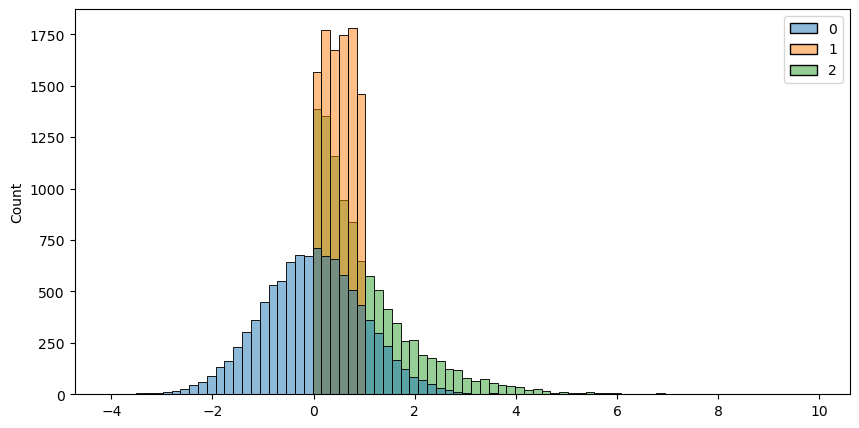

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot([X,Y,Z], bins=80);

In [16]:
distr_name = list(zip((X, Y, Z), ('normal_distr', 'uniform_distr', 'expon_distr')))
distr_name

[(array([-0.64251339, -0.08300113, -0.96004299, ...,  0.97600696,
         -0.39829943,  0.03100908]),
  'normal_distr'),
 (array([0.79313646, 0.48459959, 0.72983964, ..., 0.96370927, 0.48651888,
         0.36151126]),
  'uniform_distr'),
 (array([3.62519136, 0.15563567, 2.12398424, ..., 0.74463693, 0.25988909,
         2.80922599]),
  'expon_distr')]

### Шапиро-Уилко

In [17]:
for distr, name in distr_name:
    print(stats.shapiro(distr), name)

ShapiroResult(statistic=0.9998635649681091, pvalue=0.8496323227882385) normal_distr
ShapiroResult(statistic=0.9533578753471375, pvalue=0.0) uniform_distr
ShapiroResult(statistic=0.8201448321342468, pvalue=0.0) expon_distr


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Колмогоров-Смирнов

In [18]:
for distr, name in distr_name:
    print(stats.kstest(distr, 'norm'), name)

KstestResult(statistic=0.012467079132915448, pvalue=0.08857985189965845) normal_distr
KstestResult(statistic=0.5000354726603488, pvalue=0.0) uniform_distr
KstestResult(statistic=0.500042763414697, pvalue=0.0) expon_distr


In [19]:
for distr, name in distr_name:
    print(stats.kstest(distr, 'uniform'), name)

KstestResult(statistic=0.5058, pvalue=0.0) normal_distr
KstestResult(statistic=0.008849160391310174, pvalue=0.41152662552685004) uniform_distr
KstestResult(statistic=0.37549999999999994, pvalue=0.0) expon_distr


In [20]:
for distr, name in distr_name:
    print(stats.kstest(distr, 'expon'), name)

KstestResult(statistic=0.5058, pvalue=0.0) normal_distr
KstestResult(statistic=0.36789883001079193, pvalue=0.0) uniform_distr
KstestResult(statistic=0.008744789691556343, pvalue=0.4265017421405024) expon_distr


### Библиотека distfit

In [ ]:
#pip install distfit
from distfit import distfit

# Initialize for discrete distribution fitting
dfit = distfit(distr=[
    'norm', 'uniform', 'expon'
])

# Run distfit to and determine whether we can find the parameters from the data.
result = dfit.fit_transform(Y)

In [ ]:
result['model']